In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial',size=8)


In [2]:
exit_flux_data = rf"./data/fluxes_right.h5"
data_exit =AM.read_hdf5_as_dict(exit_flux_data)
data_exit.keys()
# data_field_intensities key containes the flux
            

dict_keys(['chi', 'data_field_intensities', 'f', 'sample', 'size'])

In [3]:
data_exit["data_field_intensities"].shape # (num_chi, num_size, sample, num_freq)

(13, 16, 5, 150)

In [4]:
mean_exit = np.mean(data_exit["data_field_intensities"], axis=2) #This is the flux not the intensity, I mistook when labeling the code
ref_exit = data_exit["data_field_intensities"][-1,:,0,:]


In [5]:
# #gap data from Luis 
# luis_gap_data_path = rf"H:\phd stuff\tidy3d\Notebooks\2D SHU Project\20250623 MPB Bands\Luis Data\band_structure_stats\20251218_bandgaps_chi_0p30_0p40_tolerance_0.02.h5"
# gap_data_luis = AM.read_hdf5_as_dict(luis_gap_data_path)

low_nDOS_boundaries=np.array([[0.297,0.297,0.299,0.303,0.308,0.315,0.323,0.333,0.338,0.343,0.354, 0.375, 0.380,0.380,0.384, 0.387, 0.390,0.394,0.398,0.401,0.404,0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.31, 0.30, 0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

# PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3650,0.3659,0.3632,  0.3643, 0.3675,0.3677,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
#                          [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.34,0.33,0.32,0.32,0.33,0.34,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

PBG_boundaries=np.array([[0.297, 0.297 ,0.299, 0.3221,0.356,0.3679,0.3767,0.3833,0.3869, 0.401, 0.404, 0.407 ],
                         [0.40 , 0.39 , 0.38, 0.37,0.36,0.35,0.35,0.36,0.37, 0.38 , 0.39, 0.40]])

half = low_nDOS_boundaries[0].size // 2

band_edge_array =(np.c_[low_nDOS_boundaries[0, :half], low_nDOS_boundaries[0, :half-1:-1]])[::-1]

gap_limit = band_edge_array[7]  # for chi=0.37

8


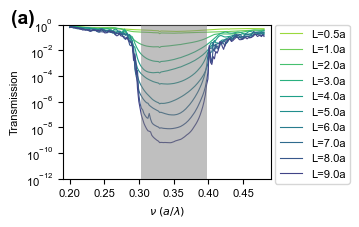

In [6]:
#transmission!!!!!

for i,chi in enumerate(data_exit["data_field_intensities"]):
    if data_exit["chi"][i] != 0.37:
        continue
    print(i)
    fig, ax = plt.subplots(figsize=(3.5,2))
    # create a degrading set of colors (bright -> pale)
    n_lines = min(10, chi.shape[0])
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0.85, 0.2, n_lines))
    for j,length in enumerate(chi): 
        if j >9:
            break
        transmission_normalized_exit =  mean_exit[i,j,:] / ref_exit[j,:]
        ax.plot(data_exit["f"]/td.C_0,
                transmission_normalized_exit,
                label=rf"L={data_exit['size'][j]}a",
                color=colors[j],
                linewidth=0.8)

    ax.axvspan(gap_limit[0], gap_limit[1], facecolor='gray', alpha=0.5, edgecolor='none', zorder=1000, clip_on=False)


    plt.xlabel(rf'$\nu$ $(a/\lambda)$')
    plt.ylabel('Transmission')
    plt.yscale("log")
    # plt.title(rf"$\chi$={data_exit["chi"][i]}")
    plt.ylim(1e-12,1)
    plt.xlim(0.19,0.49)
    xticks = np.arange(0.20, 0.481, 0.05)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{t:.2f}" for t in xticks])
    ax.tick_params(axis='x', which='both', labelbottom=True)

    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=8)
    fig.subplots_adjust(right=0.72)  # leave space for the legend
    subplot_label = rf"({chr(97)})"  # chr(97) = 'a', chr(98) = 'b', etc.
    ax.text(-0.25, 1.1, subplot_label, transform=ax.transAxes,fontsize=14, fontweight='bold', va='top', ha='left')
    # plt.savefig(rf'./figures/transmission_chi_{data_exit["chi"][i]:.2f}.pdf', bbox_inches='tight',dpi=300)
    plt.show()

In [7]:
#Get exponential decay from the gap centers 
gap_center = (gap_limit[0] + gap_limit[1])/2


index_min = np.argmin(np.abs(data_exit["f"]/td.C_0 - gap_center))

gap_min_transmissions = (np.mean(data_exit["data_field_intensities"][8],axis=1)[:,index_min])/ref_exit[:,index_min]


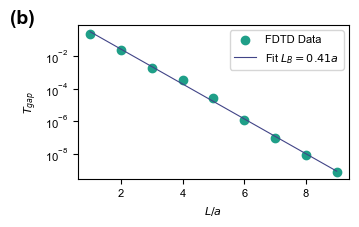

In [8]:
fig, ax = plt.subplots(figsize=(3.5,2)) 
x =  (data_exit["size"][1:10])
y =(gap_min_transmissions[1:10])
ax.scatter(x,y, color=colors[4],label="FDTD Data")
p, cov = np.polyfit(x, np.log(y), deg=1, cov=True)
# Reconstruct exponential fit
y_fit = np.exp(np.polyval(p, x))
L_B = -1/p[0]
ax.plot(x, y_fit, linewidth=0.8,label = f'Fit $L_B = {L_B:.2f}a$',color=colors[-1])

plt.xlabel(rf'$L/a$')
plt.ylabel(rf'$T_{{gap}}$')
plt.yscale("log")
plt.legend()
subplot_label = rf"({chr(98)})"  # chr(97) = 'a', chr(98) = 'b', etc.
ax.text(-0.25, 1.1, subplot_label, transform=ax.transAxes,fontsize=14, fontweight='bold', va='top', ha='left')
# plt.savefig(rf'./figures/gap_transmission_chi_{data_exit["chi"][8]:.2f}.pdf', bbox_inches='tight',dpi=300)
plt.show()

In [9]:
mean_exit.shape # (num_chi, num_size, num_freq) chi=8 is the 0.37

(13, 16, 150)

In [10]:
transmission_chi_37_L = mean_exit[8] / ref_exit  # shape (num_size, num_freq)
sizes = data_exit['size'][3:11]
freqs = data_exit["f"]/td.C_0
transmission_chi_37_L.shape

(16, 150)

In [13]:
def model_func(L,lt,b):
    return lt/(L) + b

lt_array = []

for k,item in enumerate(freqs):
    if item >=0.25:
        continue
    x,y=sizes,transmission_chi_37_L[3:11,k]
    popt, pcov = curve_fit(model_func, x, y, p0=[1,1],maxfev=10000)
    lt_array.append(popt[0])
    fit_curve = model_func(x, *popt)
    plt.scatter(x,y)
    plt.xlabel(rf'$L/a$')
    plt.ylabel(rf'$T_{{diff}}(L)$')
    plt.plot(x, fit_curve, linewidth=0.8,label = f'$l^*/L$',color=colors[-1])
    plt.legend()
    plt.close()

In [16]:
lt_array = np.array(lt_array)
(lt_array)

array([0.12039697, 0.32291771, 0.43737726, 0.56068392, 0.70482235,
       0.69550695, 0.69065521, 0.65225277, 0.65135449, 0.60698173,
       0.6667565 , 0.68753506, 0.74934595, 0.68374552, 0.79068795,
       0.76014257, 0.87340431, 0.7300719 , 0.59405319, 0.68896308,
       0.65936804, 0.6270553 , 0.6735981 , 0.86964483, 0.67707836,
       0.57265842, 0.70543773])